# Import libraries

In [ ]:
# To install required packages, run pip install -r requirements.txt in the terminal
# libraries for data processing and cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import date

# Libraries for time series modelling
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.models import AutoARIMA
from darts.models import RNNModel
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler

c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import and clean visitation data

In [2]:
with open('./2025 Allianz Datathon Dataset.xlsx - Visitation Data.csv') as f:
    reader = csv.reader(f)
    visitation_data = [list(c) for c in zip(*reader)]
visitation_data = visitation_data[:-4] # filtering out empty columns of data

ex_year = visitation_data[0][1:] # year
ex_week = visitation_data[1][1:] # week
ex_daySince2014 = visitation_data[2][1:] # days since 2014

In [3]:
headers = [col[0].strip() for col in visitation_data]
rows = list(zip(*[col[1:] for col in visitation_data]))

df = pd.DataFrame(rows, columns=headers)
df.head()

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^\w\s]", "", regex=True)
              .str.replace(" ", "_")
)

for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="ignore")

for c in ["year", "week"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# datetime column
start_year = 2014
end_year = 2024
season_start_month = 6
season_start_day = 9
weeks_per_season = 15

dates = []
for year in range(start_year, end_year + 1):
    start_date = pd.Timestamp(year=year, month=season_start_month, day=season_start_day)
    # Generate weekly dates
    weekly_dates = [start_date + pd.Timedelta(days=7*i) for i in range(weeks_per_season)]
    dates.extend(weekly_dates)
# Add new datetime column
df["date"] = dates
df = df.drop(columns=["day_since_2014"])

# id columns we want to keep as identifiers
id_cols = ["year", "week", 'date']

# everything else are resorts
resort_cols = [c for c in df.columns if c not in id_cols]

# reshape
df_visitation_clean = df.melt(
    id_vars=id_cols,
    value_vars=resort_cols,
    var_name="resort",
    value_name="visitors"
)

# visitors as numbers
df_visitation_clean["visitors"] = pd.to_numeric(df_visitation_clean["visitors"], errors="coerce")
df_visitation_clean.head()

C:\Users\haili\AppData\Local\Temp\ipykernel_49124\3467566586.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


,year,week,date,resort,visitors
0,2014,1,2014-06-09,mt_baw_baw,555
1,2014,2,2014-06-16,mt_baw_baw,804
2,2014,3,2014-06-23,mt_baw_baw,993
3,2014,4,2014-06-30,mt_baw_baw,2976
4,2014,5,2014-07-07,mt_baw_baw,11112


# Time series modelling for visitation data

## Convert data to time series with a weekly frequency

In [4]:
resort_ts_dict = {}
df_visitation_clean['std_date'] = df_visitation_clean['date']-pd.to_timedelta(df_visitation_clean['date'].dt.dayofweek, unit='D')

full_range = pd.date_range(
        start=pd.to_datetime('2014-01-01'),
        end=pd.to_datetime('2024-12-31'), 
        freq='W-MON'
    )
for resort in df_visitation_clean['resort'].unique():
    resort_data = df_visitation_clean[df_visitation_clean['resort'] == resort]
    complete_data = resort_data.set_index('std_date').reindex(full_range, fill_value=0) # zero visitors when the resorts are closed
    complete_data.index.name = 'std_date'
    complete_data = complete_data.reset_index()
    resort_ts_dict[resort] = TimeSeries.from_dataframe(
        complete_data,
        time_col='std_date', 
        value_cols='visitors',
        freq='W-MON'
    )

## Forecast using exponential smoothing 

In [5]:
pred_exp_smooth = {}

split_date = pd.Timestamp('2023-01-01')
for key,value in resort_ts_dict.items():
    train, val = resort_ts_dict[key].split_after(split_date)
    model_exp_smooth = ExponentialSmoothing()
    model_exp_smooth.fit(train)
    pred_exp_smooth[key] = model_exp_smooth.predict(len(val)*2, num_samples=1000)

c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


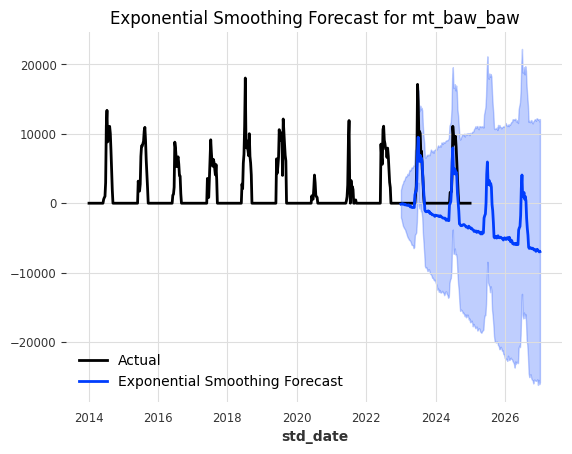

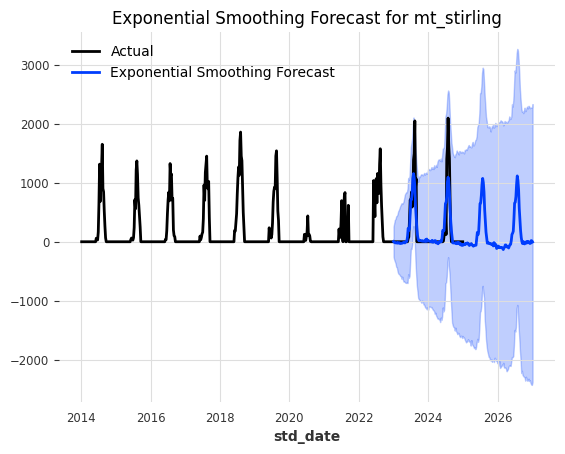

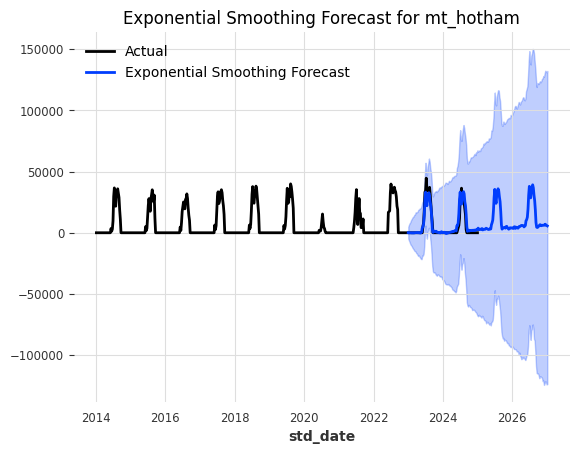

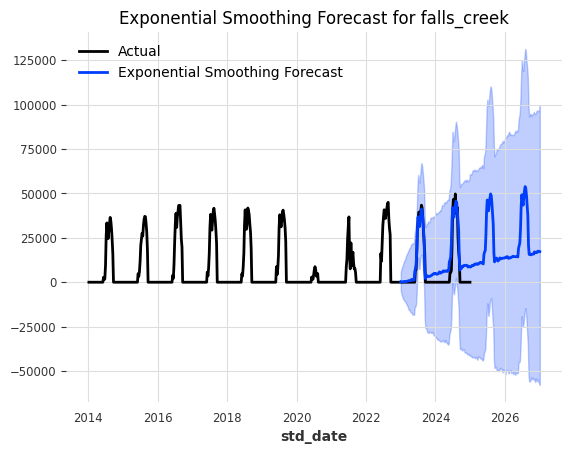

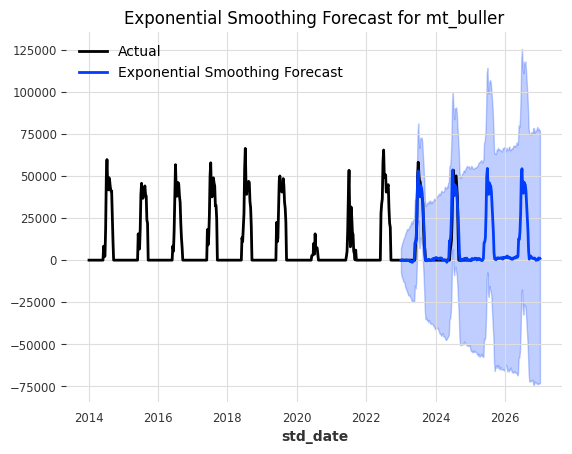

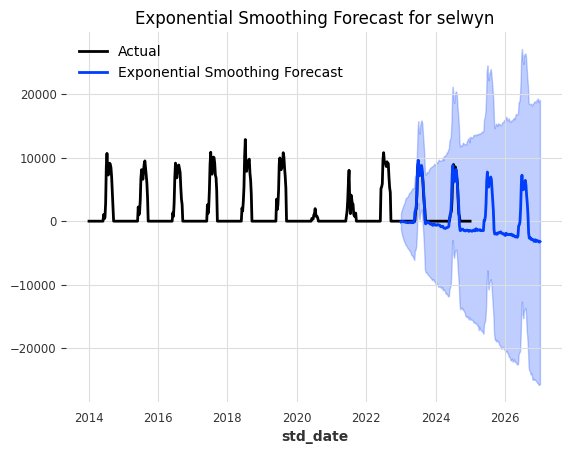

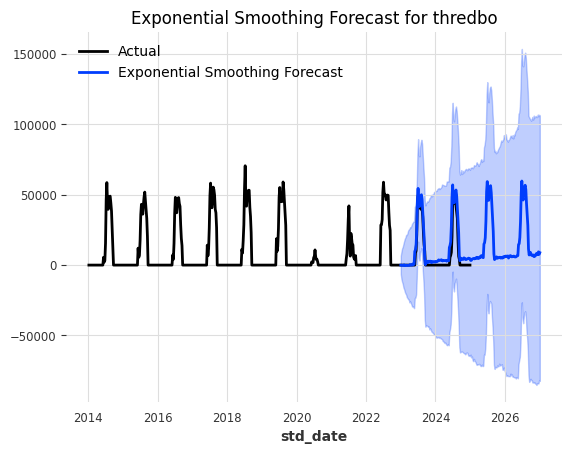

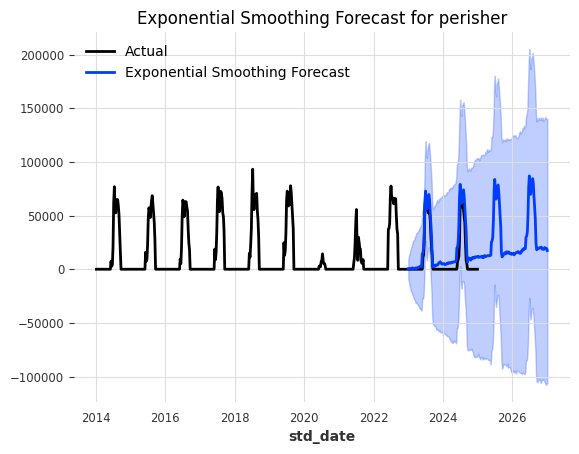

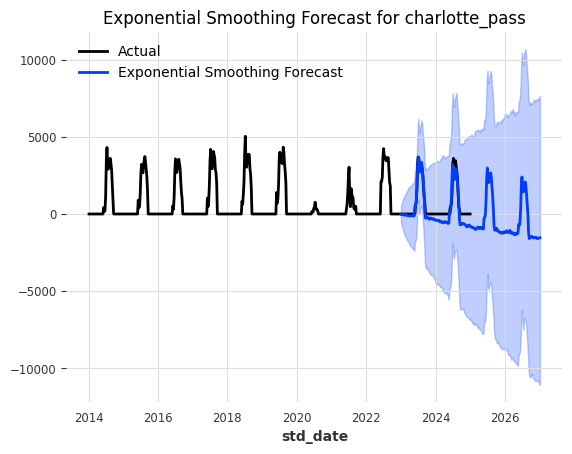

In [6]:
for key in pred_exp_smooth.keys():
    resort_ts_dict[key].plot(label='Actual')
    pred_exp_smooth[key].plot(label='Exponential Smoothing Forecast',  low_quantile = 0.05, high_quantile = 0.95)
    plt.legend()
    plt.title(f'Exponential Smoothing Forecast for {key}')
    plt.show()

Comments on the forecast performance:
1. Wide confidence interval suggests high uncertainty with the point estimates.
2. Non-zero values forecasted for off-season periods.
3. Model assumes a linear trend even during off-season which skewed the predictions.

Potential improvements on the model:
- Try to put in-season months back to back in the time series.
- Manually adjust the off-season values to be zero and remove the trend effect on in-season data forecasts.

## Forecast using AutoARIMA

In [7]:
pred_arima = {}

split_date = pd.Timestamp('2023-01-01')
for key,value in resort_ts_dict.items():
    train, val = resort_ts_dict[key].split_after(split_date)
    model_arima = AutoARIMA(
        seasonal=True,
        season_length=52,   # yearly cycle (weekly data)
        max_p=2, max_q=2,   # allow more flexibility
        max_P=1, max_Q=1,   # seasonal orders
        d=None, D=None,     # let auto-diff decide
        approximation=True,
    )
    model_arima.fit(train)
    pred_arima[key] = model_arima.predict(len(val)*2)

c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsforecast\arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsforecas

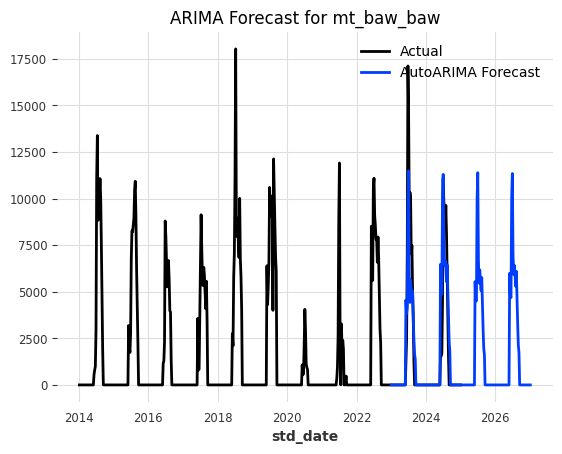

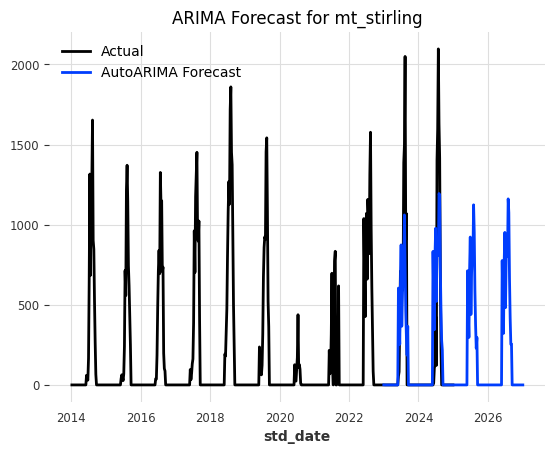

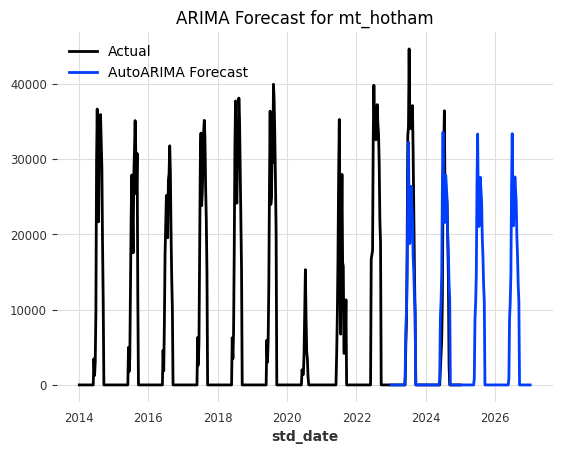

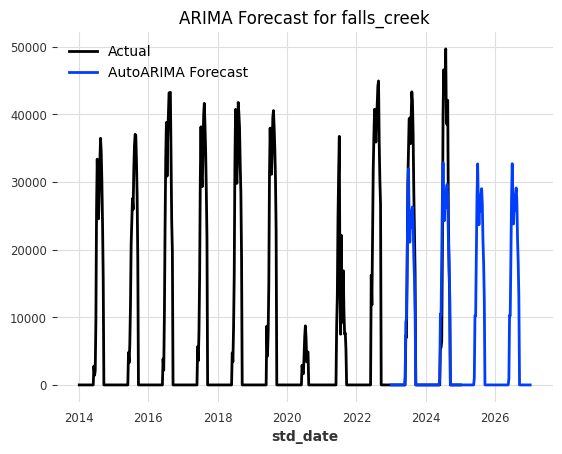

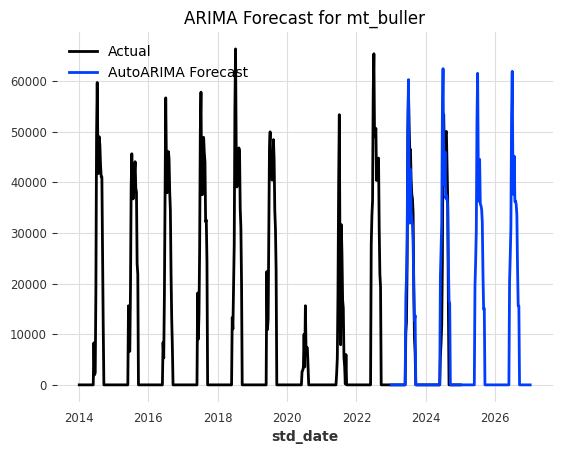

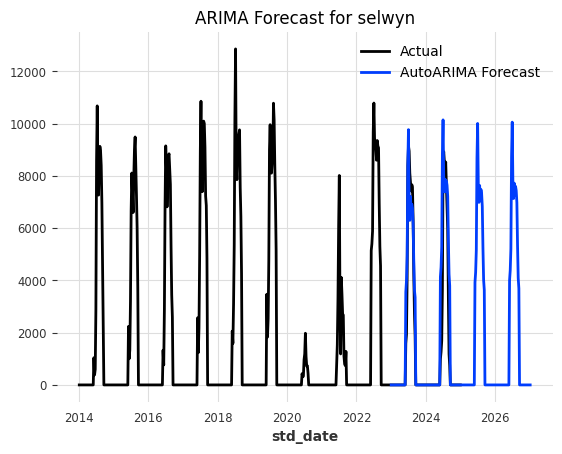

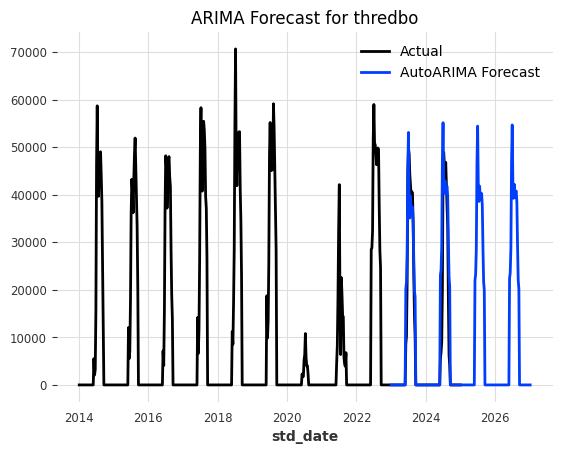

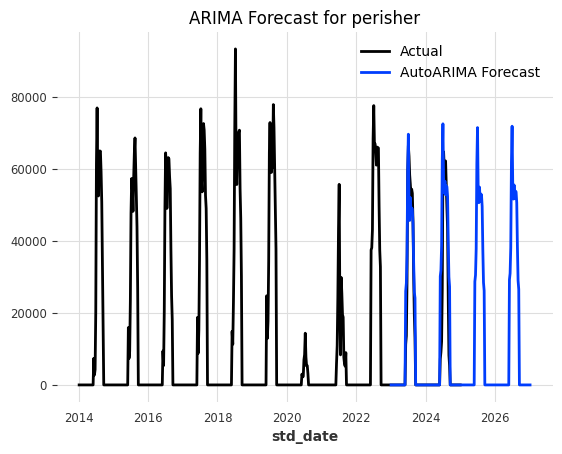

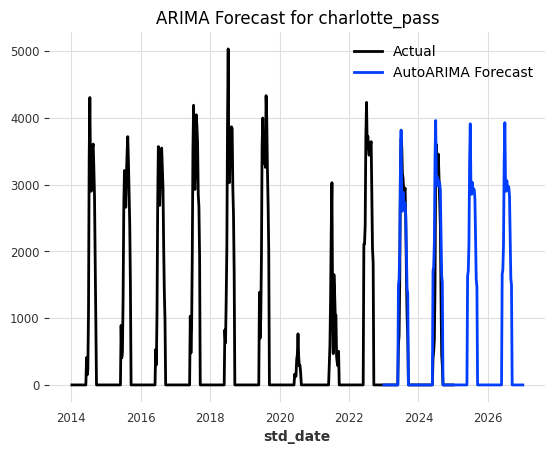

In [8]:
for key in pred_arima.keys():
    resort_ts_dict[key].plot(label='Actual')
    pred_arima[key].plot(label='AutoARIMA Forecast',  low_quantile = 0.05, high_quantile = 0.95)
    plt.legend()
    plt.title(f'ARIMA Forecast for {key}')
    plt.show()

Commnets on the forecast performance:
1. ARIMA model performs better in capturing the seasonality in the data
2. The forecasts results appear to be similar across all four years.
3. This may be because that the ARIMA model does not capture external drivers (weather, events, policy, etc) in its predictions

Potential improvements on the model:
- Use SARIMAX with exogenous regressors to account for exceptional peaks and troughs.
- Address heteroskedasticity in the data through log transformation.

## Forecast using RNN - LSTM

In [9]:
pred_rnn = {}
transformer = Scaler()
train_transformed_list = []
split_date = pd.Timestamp('2023-01-01')

all_train = [ts.split_after(split_date)[0] for ts in resort_ts_dict.values()]
all_val = [ts.split_after(split_date)[1] for ts in resort_ts_dict.values()]

train_scaled = transformer.fit_transform(all_train)
val_scaled = transformer.fit_transform(all_val)

In [10]:
model_rnn = RNNModel(model='LSTM', input_chunk_length=52*2, training_length=52*2, output_chunk_length=8, n_epochs=500, random_state=42)
model_rnn.fit(train_scaled, verbose=True)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
c:\Users\haili\AppData\Local\Pr

Epoch 499: 100%|██████████| 103/103 [00:09<00:00, 10.71it/s, train_loss=0.000947]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 103/103 [00:09<00:00, 10.68it/s, train_loss=0.000947]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=104, input_chunk_length=104, output_chunk_length=8, n_epochs=500, random_state=42)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


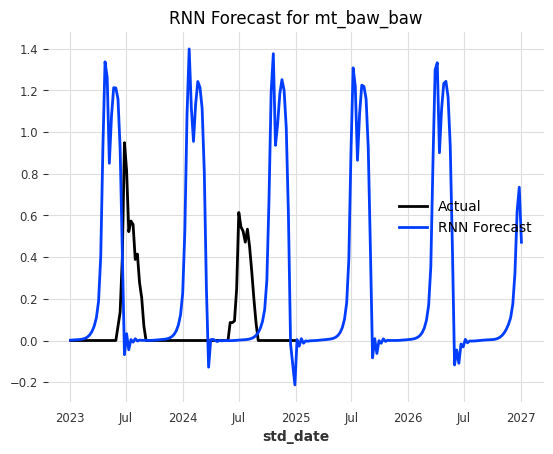

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s]


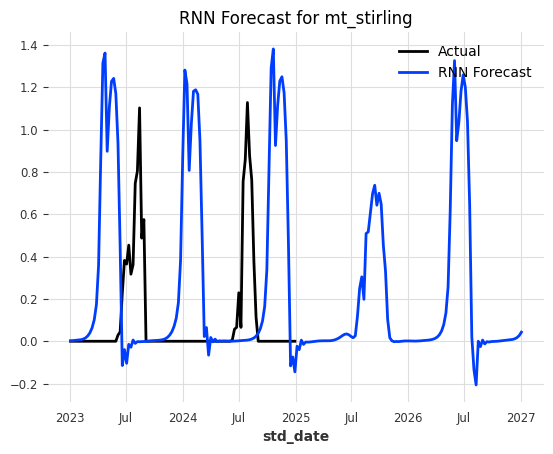

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.92it/s]


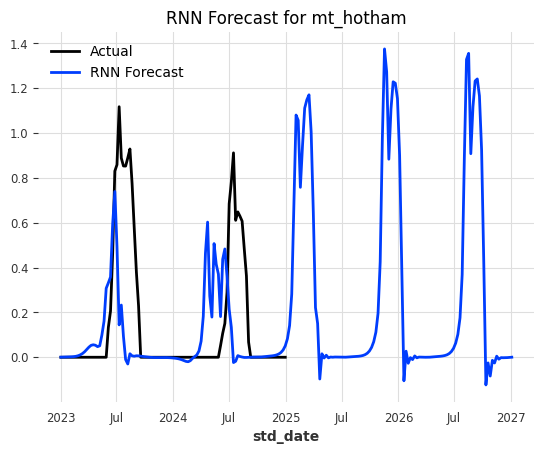

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


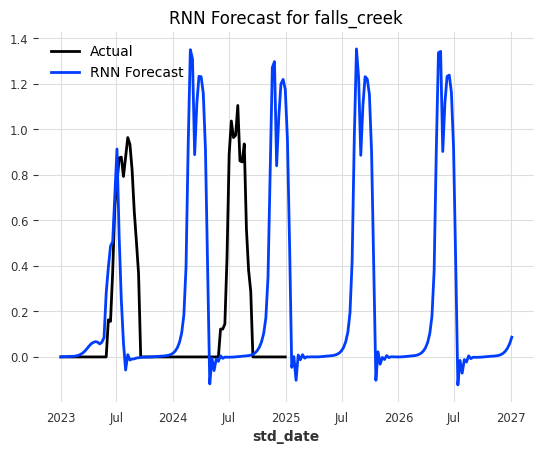

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


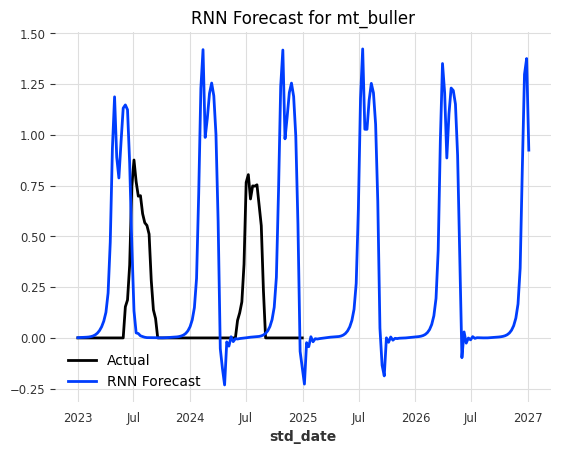

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


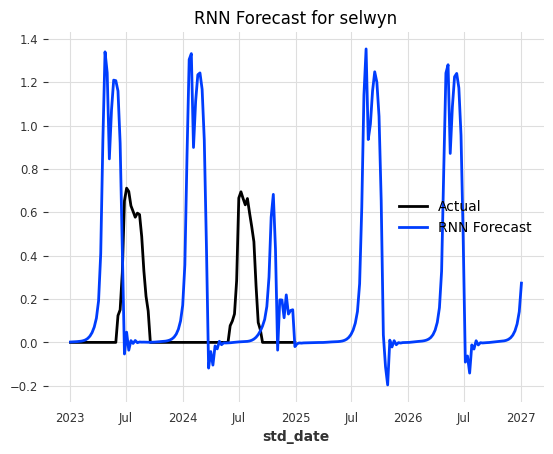

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


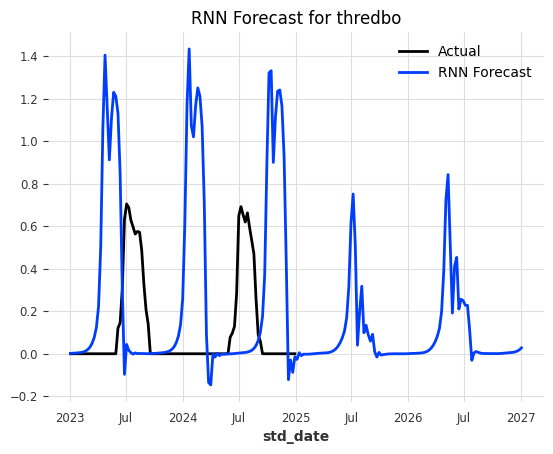

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


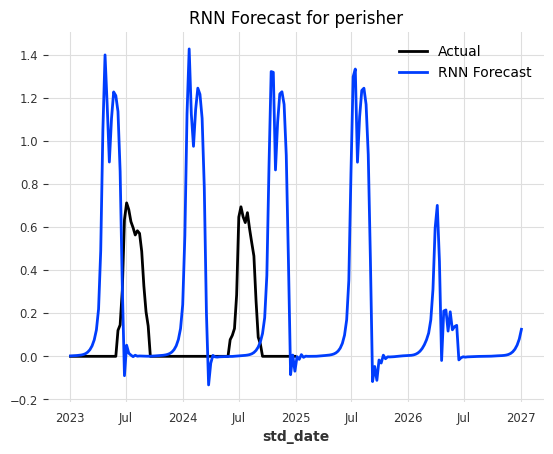

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


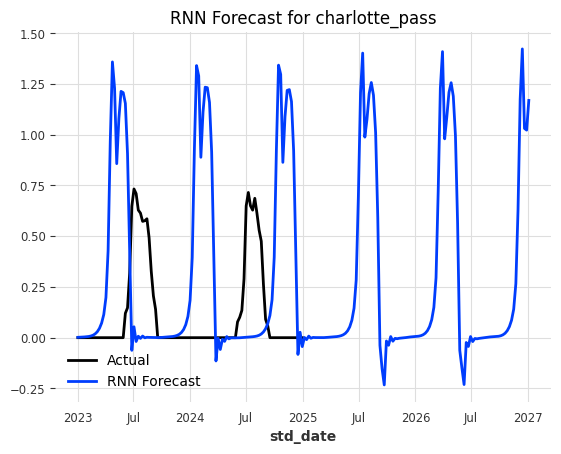

In [11]:
for key in resort_ts_dict.keys():
    train, val = resort_ts_dict[key].split_after(split_date)
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    pred_rnn[key] = model_rnn.predict(n=len(val)*2,series=train_transformed)
    val_transformed.plot(label='Actual')
    pred_rnn[key].plot(label='RNN Forecast')
    plt.legend()
    plt.title(f'RNN Forecast for {key}')
    plt.show()

Commnets on the forecast performance:
1. The forecasting results show seasonal patterns but they are mostly shifted and generally larger compare to the validation set.
2. This may be because that the model tried balancing commonalities and differences across different resorts.
 
Potential improvements on the model:
- Perform hyperparameter tuning to find the most efficient paramters for the dataset.
- Incorporate other variables that affect the number of visitors (e.g. weather).
- Instead of fitting multiple time series together, build model for each individual time series. 

## Model evaluation and backtesting

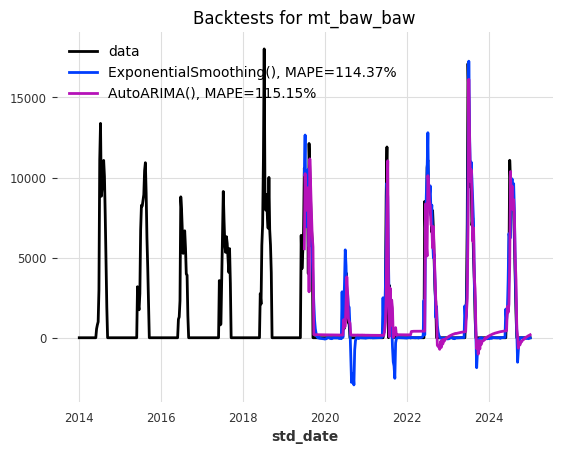

c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retval

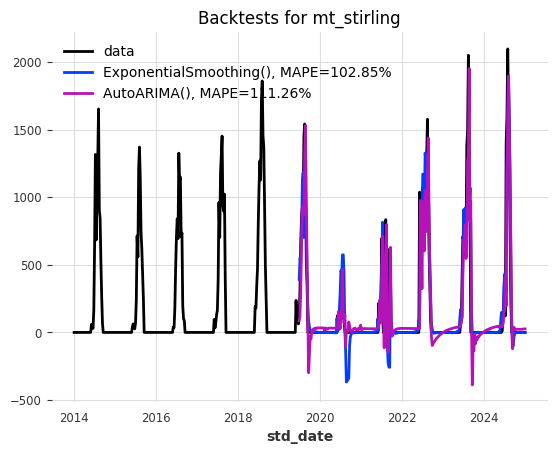

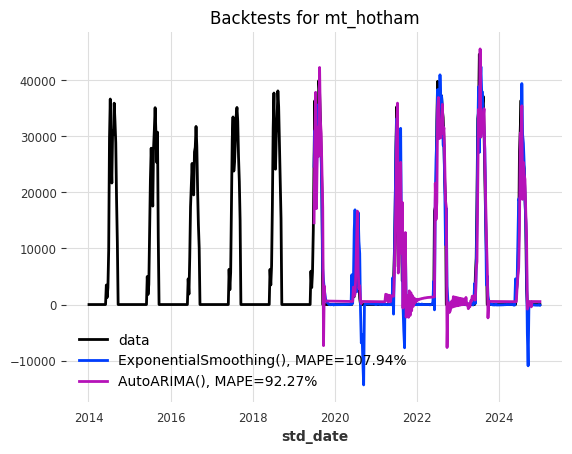

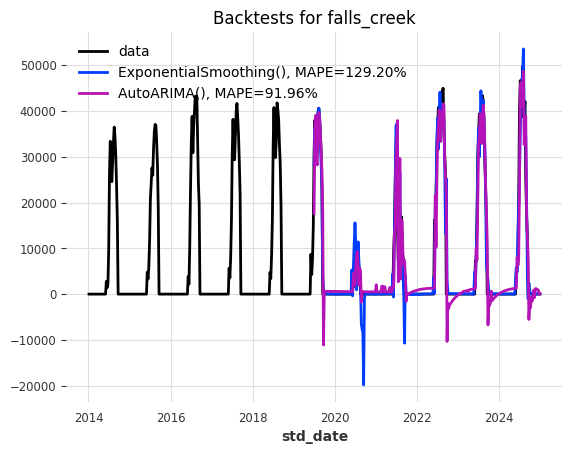

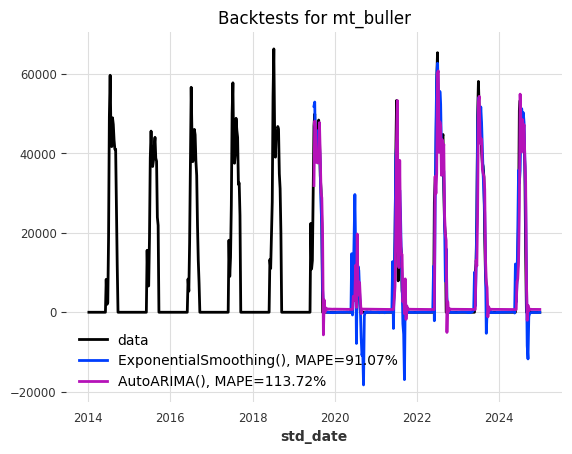

c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retval

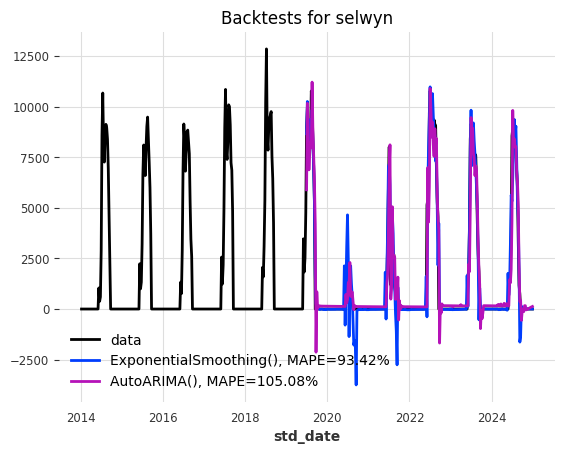

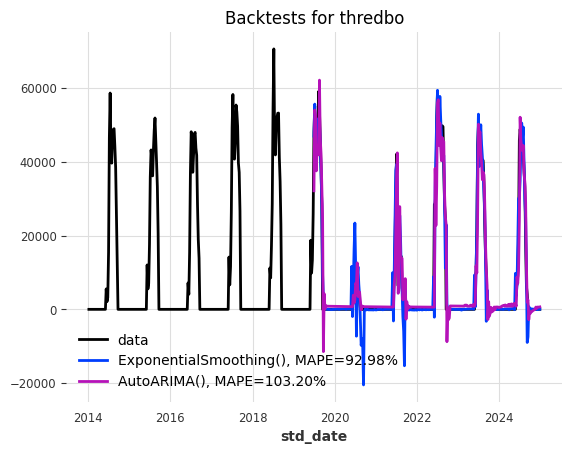

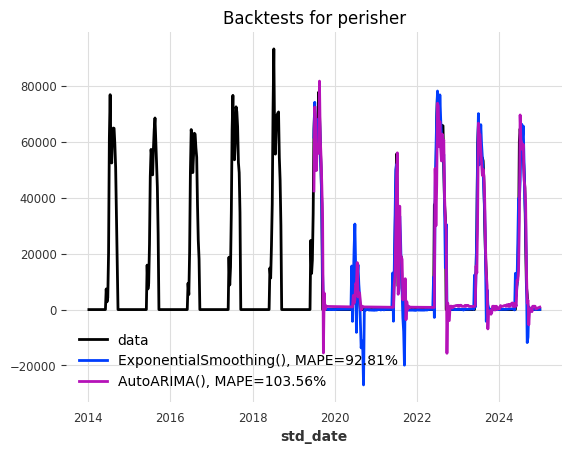

c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\haili\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retval

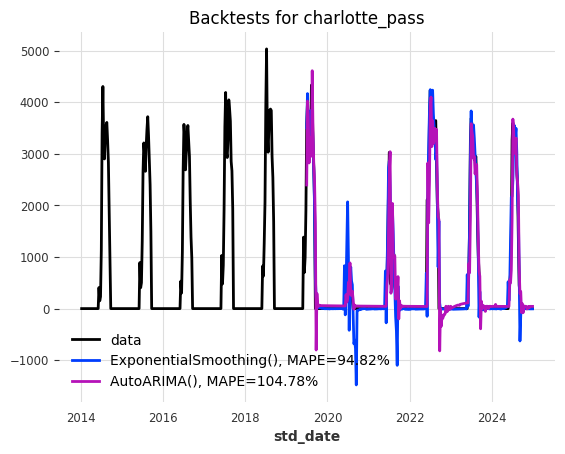

In [12]:
models = [ExponentialSmoothing(), AutoARIMA()]

for key in resort_ts_dict.keys():
    series = resort_ts_dict[key]
    backtests = [model.historical_forecasts(series, start=.5) for model in models]

    series.plot(label='data')
    for i, m in enumerate(models):
        err = mape(backtests[i], series)
        backtests[i].plot(label='{}, MAPE={:.2f}%'.format(m, err))

    plt.title(f'Backtests for {key}')
    plt.legend()
    plt.show()

## Plots comparing Exponential Smoothing and AutoARIMA forecasts

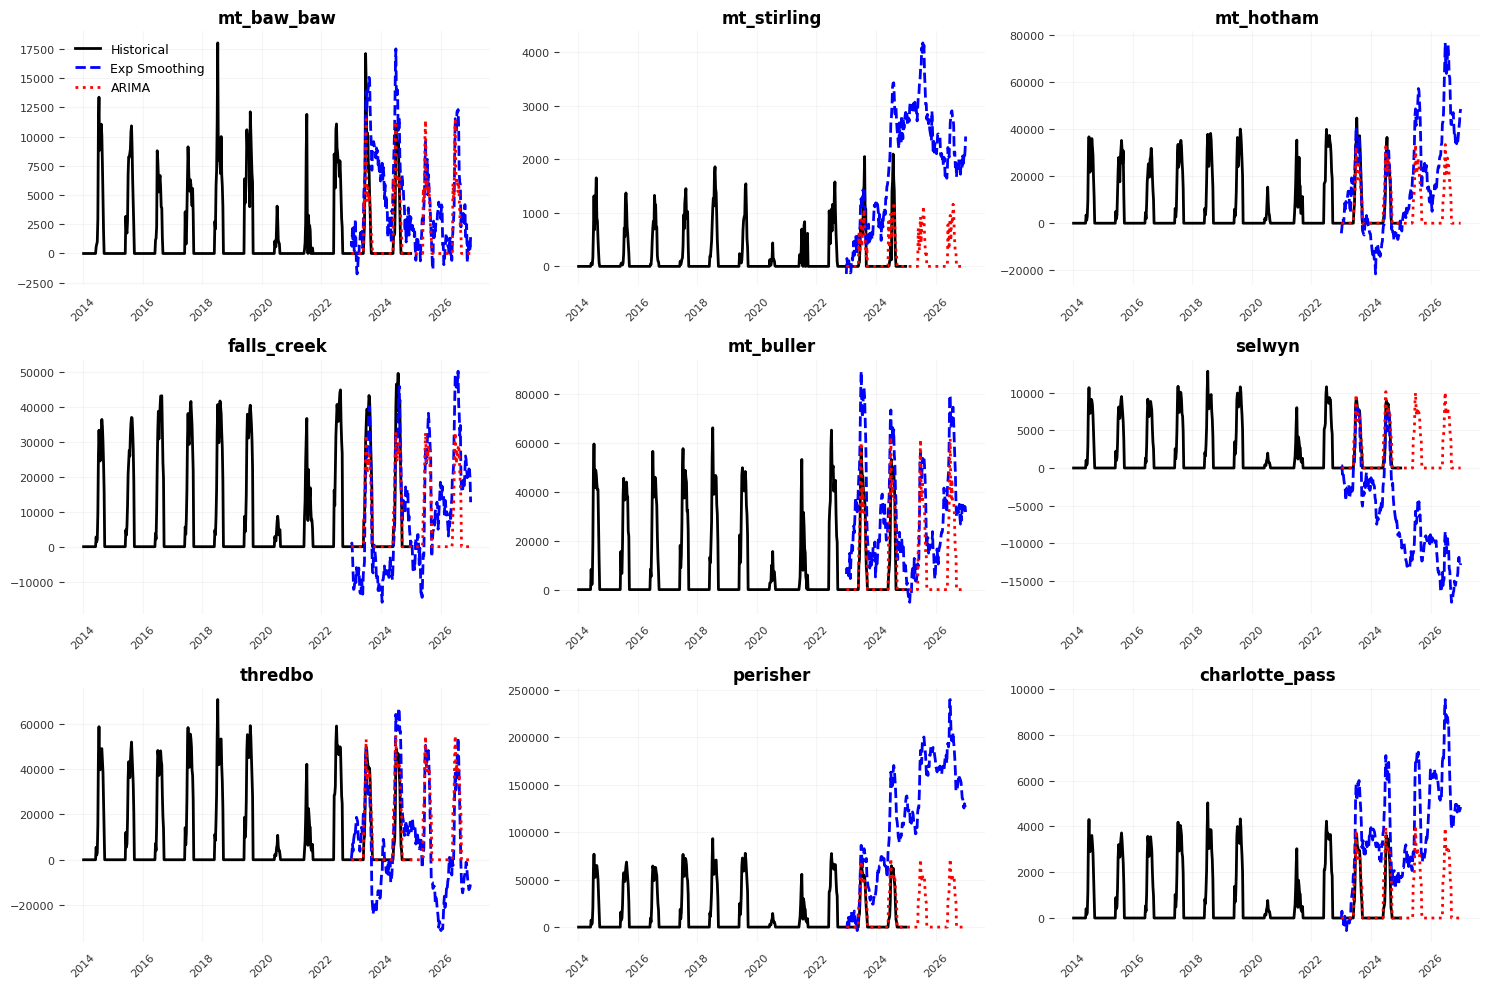

In [13]:
forecast_dict = {}
for key in resort_ts_dict.keys():
    forecast_dict[key] = {
        'historical': resort_ts_dict[key], 
        'exp_smoothing': pred_exp_smooth[key], 
        'arima': pred_arima[key], 
    }

# Create the subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

resort_keys = list(resort_ts_dict.keys())

for i, resort_key in enumerate(resort_keys):
    ax = axes[i]
    resort_data = forecast_dict[resort_key]
    
    hist_ts = resort_data['historical']
    ax.plot(hist_ts.time_index, hist_ts.values(), 
            label='Historical', color='black', linewidth=2)
    
    exp_ts = resort_data['exp_smoothing']
    ax.plot(exp_ts.time_index, exp_ts.values(), 
            label='Exp Smoothing', color='blue', linewidth=2, linestyle='--')
    
    arima_ts = resort_data['arima']
    ax.plot(arima_ts.time_index, arima_ts.values(), 
            label='ARIMA', color='red', linewidth=2, linestyle=':')
    
    ax.set_title(resort_key, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add legend only to first subplot
    if i == 0:
        ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## Calculating visitation index

In [14]:
visitor_index_dict = {}
visitor_param = -0.159

filtered_ts_dict = {}
for key in resort_keys:
    filtered_ts_dict[key] = pred_arima[key].drop_before(pd.to_datetime('2026-06-01')).drop_after(pd.to_datetime('2026-09-30'))[:15]

all_data = []
for resort_name, ts in filtered_ts_dict.items():
    dates = ts.time_index
    visitors = ts.values().flatten()  # Flatten to 1D array
     # Create temporary DataFrame for this resort
    resort_df = pd.DataFrame({
        'resort': resort_name,
        'std_date': dates,
        'visitors': visitors
        })
        
    all_data.append(resort_df)
    
    # Concatenate all resort DataFrames
    final_df = pd.concat(all_data, ignore_index=True)

final_df['visitor_index'] = np.exp(visitor_param * final_df['visitors'])
final_df = final_df[final_df['visitors']>0]

In [15]:
final_df.head()

,resort,std_date,visitors,visitor_index
0,mt_baw_baw,2026-06-08,4798.150279,0.000000e+00
1,mt_baw_baw,2026-06-15,4686.139670,4.940656e-324
2,mt_baw_baw,2026-06-22,10065.215800,0.000000e+00
3,mt_baw_baw,2026-06-29,11344.059882,0.000000e+00
4,mt_baw_baw,2026-07-06,7032.285989,0.000000e+00


In [16]:
# week and resort that maximises the visitation index
final_df.loc[final_df['visitor_index'].idxmax()]

resort                   mt_stirling
std_date         2026-09-14 00:00:00
visitors                         0.0
visitor_index                    1.0
Name: 29, dtype: object